In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

from pmd_beamphysics.wavefront import Wavefront

In [2]:
%config InlineBackend.figure_format = 'retina'

## Creating a Wavefront

In [3]:
W = Wavefront.gaussian_pulse(
    dims=(801, 101, 101),
    wavelength=1.35e-8,
    grid_spacing=(0.0625, 6e-6, 6e-6),
    pad=(40, 100, 100),
    nphotons=1e12,
    zR=2.0,
    sigma_t=5,
)

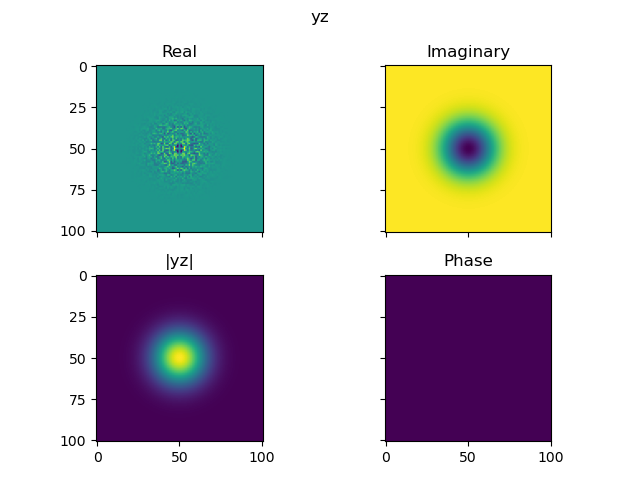

In [4]:
W.plot("yz", rspace=True);

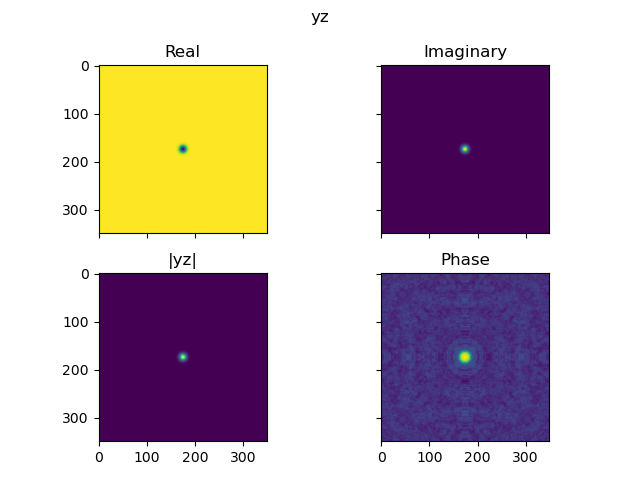

In [5]:
W.plot("yz", rspace=False);

In [6]:
nt, nx, ny = np.shape(W.rmesh)

In [7]:
print(W.rmesh.shape)

(801, 101, 101)


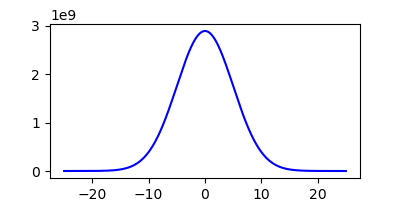

In [8]:
plt.figure(figsize=(4, 2))
plt.plot(
    W.rspace_domain[0], np.abs(W.rmesh[:, int(nx / 2), int(ny / 2)]), color="b"
)
plt.xlabel("Time [fs]");

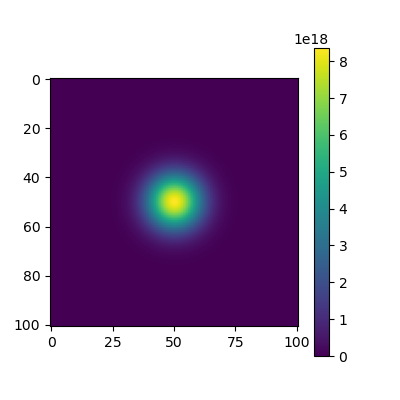

In [9]:
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(W.rmesh[int(nt / 2), :, :]) ** 2)
plt.colorbar();

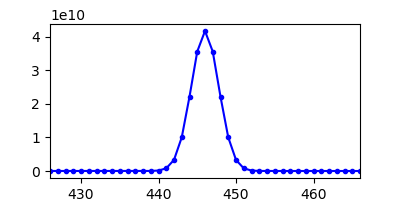

In [10]:
nw, nkx, nky = W.kmesh.shape
plt.figure(figsize=(4, 2))
kspace_slice = np.abs(W.kmesh[:, int(nkx / 2), int(nky / 2)])
plt.plot(kspace_slice, ".-", color="b")
peak_x = np.argmax(kspace_slice)
plt.xlim(peak_x - 20, peak_x + 20);

In [11]:
W.pad

WavefrontPadding(grid=(801, 101, 101), pad=(46, 124, 124))

(149.0, 199.0)

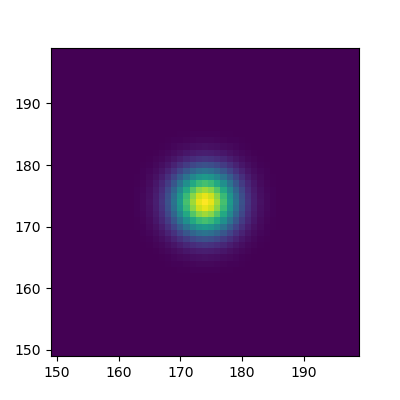

In [12]:
plt.figure(figsize=(4, 4))
kspace_image = np.abs(W.kmesh[int(nw / 2), :, :]) ** 2

center = np.argmax(kspace_image, axis=0)[0]
plt.imshow(kspace_image)
plt.xlim(center - 25, center + 25)
plt.ylim(center - 25, center + 25)

## Propagation

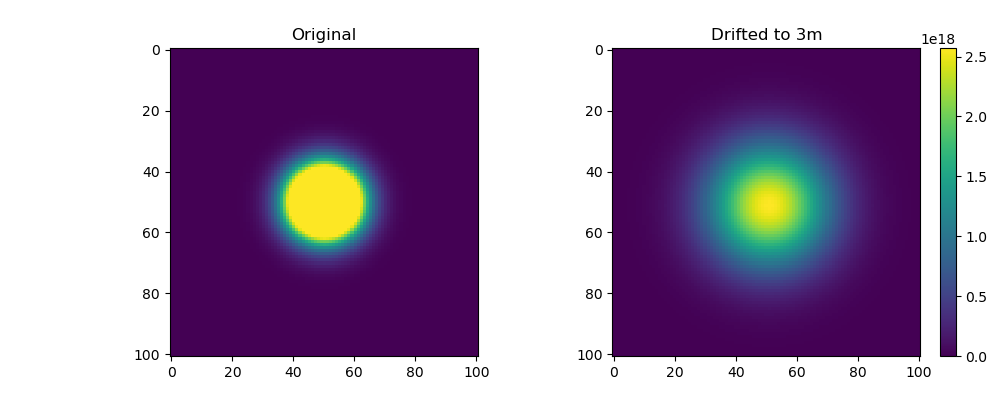

In [13]:
drifted_w = W.drift("z", 3)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

rspace_abs_orig = np.abs(W.rmesh[int(nt / 2), :, :]) ** 2
rspace_abs_prop = np.abs(drifted_w.rmesh[int(nt / 2), :, :]) ** 2
vmin = np.min((np.min(rspace_abs_orig), np.min(rspace_abs_prop)))
vmax = np.min((np.max(rspace_abs_orig), np.max(rspace_abs_prop)))
im1 = ax1.imshow(rspace_abs_orig, vmin=vmin, vmax=vmax)
im2 = ax2.imshow(rspace_abs_prop, vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=1.0)
plt.colorbar(im2)
ax1.set_title("Original")
ax2.set_title("Drifted to 3m");

In [14]:
def gaussian_func(x, a, b, c, d):
    return a * np.exp(-((x - b) ** 2) / 2.0 / c**2) + d


def gaussian_fit(xdata, ydata, initial_guess):
    popt_gaussian, pcov_gaussian = curve_fit(
        gaussian_func, xdata, ydata, p0=initial_guess
    )
    FWHM = popt_gaussian[2] * 2.355

    ydata_fit = gaussian_func(xdata, *popt_gaussian)

    spline = UnivariateSpline(xdata, ydata_fit - np.max(ydata_fit) / 2.0, s=0)
    r1, r2 = spline.roots()

    roots = [r1, r2]

    return popt_gaussian, ydata_fit, FWHM, roots

In [15]:
zR = 2.0
X = Wavefront.gaussian_pulse(
    dims=(801, 101, 101),
    wavelength=1.35e-8,
    grid_spacing=(0.0625, 6e-6, 6e-6),
    pad=(40, 100, 100),
    nphotons=1e12,
    zR=zR,
    sigma_t=5,
)

mz = 3
zgrid = 5
dz = 0.25

wfz = np.zeros((mz * zgrid, X.pad.grid[1], X.pad.grid[2]))
fwhmz_fit = np.zeros(mz * zgrid)

w0 = np.sqrt(zR * X.wavelength / np.pi)
z = np.linspace(
    -mz * zgrid * dz,
    mz * zgrid * dz + dz,
    2 * mz * zgrid + 1,
    endpoint=False,
)
wz = w0 * np.sqrt(1 + (z / zR) ** 2)

domain_x = X.rspace_domain[1]

X.drift("z", 0.0, inplace=True)

for zi in range(0, mz * zgrid):
    if zi > 0:
        print("Propagating to: ", zi * dz)
        X.drift("z", dz, inplace=True)
    wf = np.abs(X.rmesh[int(nt / 2), :, :]) ** 2

    popt_gaussian, ydata_fit, FWHM, roots = gaussian_fit(
        domain_x,
        np.sum(wf, axis=1),
        [8e19, 0.0, 0.0002, 0.0],
    )
    wfz[zi, :, :] = wf
    fwhmz_fit[zi] = FWHM

wfz_wx = np.sum(wfz, axis=1)
wfz_wx2 = np.vstack((np.flip(wfz_wx, axis=0), wfz_wx))

/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/ipykernel_87854/2769781817.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_gaussian, pcov_gaussian = curve_fit(


Propagating to:  0.25
Propagating to:  0.5
Propagating to:  0.75
Propagating to:  1.0
Propagating to:  1.25
Propagating to:  1.5
Propagating to:  1.75
Propagating to:  2.0
Propagating to:  2.25
Propagating to:  2.5
Propagating to:  2.75
Propagating to:  3.0
Propagating to:  3.25
Propagating to:  3.5


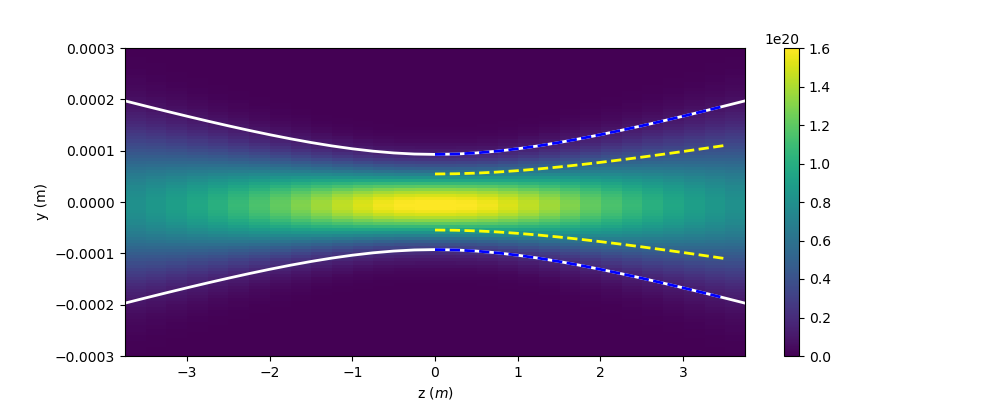

In [16]:
plt.figure(figsize=(10, 4))

ymin, ymax = X.ranges[1]

plt.imshow(
    wfz_wx2.T,
    extent=[-mz * zgrid * dz, mz * zgrid * dz, ymin, ymax],
    aspect="auto",
    vmin=0.0,
    vmax=1.6e20,
)

plt.plot(z, wz, "-", linewidth=2, color="white")
plt.plot(z, -wz, "-", linewidth=2, color="white")

plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    fwhmz_fit / np.sqrt(2.0 * np.log(2)),
    "--",
    linewidth=2,
    color="blue",
)
plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    -fwhmz_fit / np.sqrt(2.0 * np.log(2)),
    "--",
    linewidth=2,
    color="blue",
)

plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    fwhmz_fit / 2,
    "--",
    linewidth=2,
    color="yellow",
)
plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    -fwhmz_fit / 2,
    "--",
    linewidth=2,
    color="yellow",
)


plt.ylim(ymin, ymax)

plt.xlabel(r"z ($m$)")
plt.ylabel("y (m)")
plt.colorbar();